In [99]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from os import listdir, getcwd
from os.path import isfile, join
from math import radians,sin

In [100]:
def great_circle_array(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the result of meshgrid meaning they are both 2D (in degrees)
    Out put is a 2D array of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def great_circle_list(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the list of points that make up the front
    Out put is a list of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def GCD_m2deg(GCD):
    rearth = 6371000 #meters
    return (GCD / (2*np.pi*rearth)) * 360

def GCD_deg2m(GCD):
    rearth = 6371000 #meters
    return (GCD / 360) * (2*np.pi*rearth)

In [2]:
path = 'WPC_CODSUS/lores/2003'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
onlyfiles.sort()

In [8]:
with open(path+'/'+onlyfiles[0]) as f:
    lines = f.readlines()
f.close()

In [14]:
lines

['\n',
 'CODED SURFACE FRONTAL POSITIONS\n',
 'NWS HYDROMETEOROLOGICAL PREDICTION CENTER CAMP SPRINGS MD\n',
 '700 AM EST ??? JAN 03 2003\n',
 '\n',
 'VALID 010312Z\n',
 'HIGHS 1036 41109 1024 4094 1028 28100 1033 4871 1022 29130 \n',
 'LOWS 1006 3581 997 74153 974 52133 1009 3774 1005 51103 999 7497 963 41150 \n',
 '969 55159 994 4442 975 5750 \n',
 'TROF 4479 4280 4181 3881 3681 \n',
 'TROF 38104 39103 41102 43101 44101 \n',
 'WARM WK 51103 50102 48101 47101 46101 44101 44100 4399 4299 \n',
 'STNRY WK 50107 50109 50110 51112 51114 \n',
 'COLD WK 51103 50103 50105 50106 50107 50107 \n',
 'STNRY WK 55113 55114 55117 55120 55125 55127 56130 57133 58136 59141 \n',
 '60145 60150 59154 58159 56161 54161 \n',
 'COLD WK 40146 38147 35150 33153 31156 30158 \n',
 'OCFNT WK 41150 41149 41148 41147 40146 \n',
 'WARM WK 40146 39144 38142 37139 \n',
 'TROF 40150 38151 36153 35155 33157 \n',
 'COLD WK 4442 4143 3947 3750 3654 3559 3565 \n',
 'WARM WK 3774 3673 3570 3569 3566 3565 \n',
 'STNRY WK 37

['a', 1]

In [52]:
FRONT_coords = []
number = 0
while number < len(lines):
    if len(lines[number])==1:
        number+=1
    elif lines[number].split()[0] in ['WARM','STNRY','COLD','OCFNT']:
        coordlist = [lines[number].split()[0],lines[number].split()[1]]
        if lines[number+1][0].isdigit():
            front_data = lines[number].split() + lines[number+1].split()
            number+=1
        else:
            front_data = lines[number].split()
        for coords in front_data[2:]:
            coordlist.append([int(coords[:2]),int(coords[2:])])
        FRONT_coords.append(coordlist)
        number+=1
    else:
        number+=1

In [87]:
def ExtractPlotData(frt):
    lats = []
    lons = []
    for co in frt[2:]:
        lats.append(co[0])
        lons.append(-1*co[1])
        
    if frt[0] == 'WARM':
        typ = 'red'
    elif frt[0] == 'STNRY':
        typ = 'green'
    elif frt[0] == 'COLD':
        typ = 'blue'
    elif frt[0] == 'OCFNT':
        typ = 'violet'
        
    return lons,lats,typ

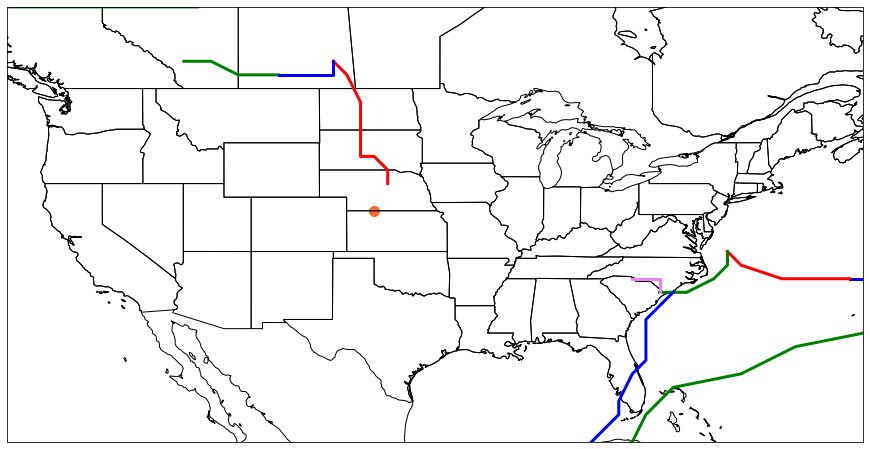

In [113]:
proj = ccrs.PlateCarree()
clon = -100
clat = 40

MyFigure = plt.figure(figsize = (16,8))
# plt.title('Pattern '+patID)

ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
ax.scatter(clon,clat,color="orangered",
            s=100,
            alpha=0.8)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

In [114]:
def GCD_Point2Front_AtTime(clon,clat,frts):
    mindist = []
    for frt in frts:
        lons,lats,_ = ExtractPlotData(frt)
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(lons),np.array(lats)))
        mindist.append(np.min(gcds))
        
    return min(mindist)

In [115]:
GCD_Point2Front_AtTime(clon,clat,FRONT_coords)

2.1376134743852457

In [118]:
llats = np.arange(23,55)
llons = np.arange(-127,-64)
dtf = np.zeros((len(llats),len(llons)))
for y in range(len(llats)):
    for x in range(len(llons)):
        dtf[y,x] = GCD_Point2Front_AtTime(llons[x],llats[y],FRONT_coords)

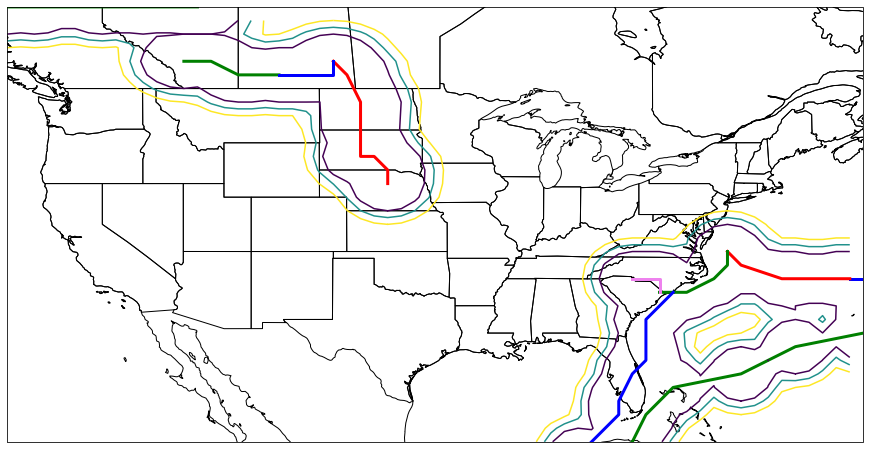

In [128]:
proj = ccrs.PlateCarree()
MyFigure = plt.figure(figsize = (16,8))
ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
ax.contour(llons,llats,dtf,levels=[2,2.5,3])
# plt.colorbar(c,orientation='horizontal')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# WITHIN ABOUT THREE GCD FROM A FRONT IT MATTERS THAT WE'RE ONLY USING THE POINTS THAT DEFINE THE FRONT RATHER THAN THE ENTIRE LINE
# OUTSIDE OF THREE GCD IT DOESN'T SEEM TO MATTER

In [132]:
def p4(p1, p2, p3):
    """
    p1 and p2 are the endpoints of the frontal segment, p3 is the target point (where the rain is) and p4 is the closest point on the line definied by p1 and p2 to p3
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    dx, dy = x2-x1, y2-y1
    det = dx*dx + dy*dy
    a = (dy*(y3-y1)+dx*(x3-x1))/det
    return x1+a*dx, y1+a*dy

In [142]:
def GCD_Point2Front_AtTime_mkII(clon,clat,frts):
    mindist = []
    for frt in frts:
        lons,lats,_ = ExtractPlotData(frt)
        npxs = []
        npys = []
        for seg in range(len(lons)-1):
            near_point = p4([lons[seg],lats[seg]],[lons[seg+1],lats[seg+1]],[clon,clat])
            npys.append(near_point[0])
            npxs.append(near_point[1])
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(npys),np.array(npxs)))
        mindist.append(np.min(gcds))
        
    return min(mindist)

In [143]:
llats = np.arange(23,55)
llons = np.arange(-127,-64)
dtf_mkII = np.zeros((len(llats),len(llons)))
for y in range(len(llats)):
    for x in range(len(llons)):
        dtf_mkII[y,x] = GCD_Point2Front_AtTime_mkII(llons[x],llats[y],FRONT_coords)

/var/folders/5m/jk5ykktj1md4gv4vh9t4m8xc0000gn/T/ipykernel_86186/3482566850.py:10: RuntimeWarning: invalid value encountered in long_scalars
  a = (dy*(y3-y1)+dx*(x3-x1))/det


/var/folders/5m/jk5ykktj1md4gv4vh9t4m8xc0000gn/T/ipykernel_86186/1477965344.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(c,orientation='horizontal')


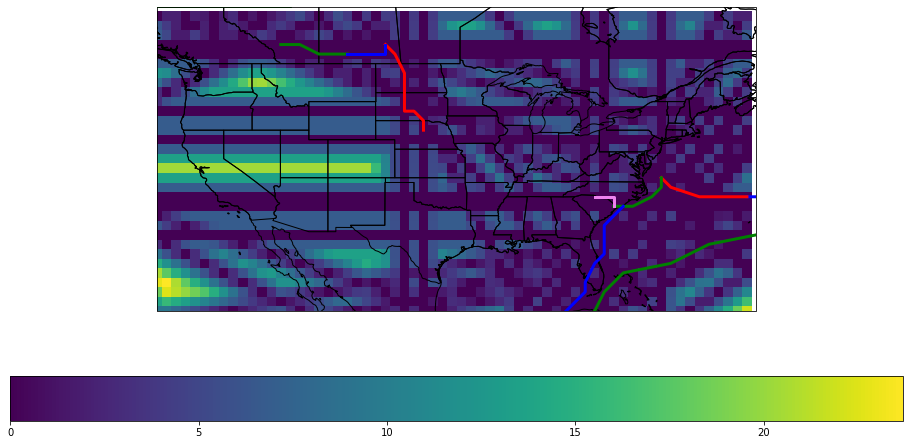

In [144]:
proj = ccrs.PlateCarree()
MyFigure = plt.figure(figsize = (16,8))
ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
ax.pcolormesh(llons,llats,dtf_mkII)
plt.colorbar(c,orientation='horizontal')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

In [136]:
np.where(dtf_mkII==0)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 